In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [3]:
time_steps = np.linspace(0, 50, 500)
data = np.sin(time_steps) + np.random.normal(0, 0.1, len(time_steps))

scaler = MinMaxScaler(feature_range=(-1, 1))
data = scaler.fit_transform(data.reshape(-1, 1))

def create_sequence_data(data, seq_length):
    X = []
    y = []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i])
        y.append(data[i])

    return torch.tensor(np.array(X), dtype=torch.float), torch.tensor(np.array(y), dtype=torch.float)

X, y = create_sequence_data(data, 10)

X_train, y_train = X[:400], y[:400]
X_test, y_test = X[400:], y[400:]

class CustomDataset(Dataset):
    def __init__(self, X, y):
        super().__init__()
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = CustomDataset(X_train, y_train)
test_dataset = CustomDataset(X_test, y_test)
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)

class Transformer(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(1, 64)
        decoder_layer = nn.TransformerDecoderLayer(
            d_model=64,
            nhead=4,
            dim_feedforward=256,
            dropout=0.1,
            batch_first=True
        )
        self.transformer_decoder = nn.TransformerDecoder(
            decoder_layer,
            num_layers=4
        )
        self.decoder = nn.Linear(64, 1)

    def forward(self, X):
        tgt = self.linear(X)
        tgt += nn.Parameter(torch.zeros(X.shape))
        out = self.transformer_decoder(tgt, tgt)
        return self.decoder(out[:, -1, :])

model = Transformer()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

num_epochs = 100
best_model_dict = None
best_train_loss = float('inf')
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for X, y in train_dataloader:
        optimizer.zero_grad()
        y_pred = model(X)
        loss = criterion(y_pred, y)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
    train_loss /= len(train_dataloader)
    if best_train_loss > train_loss:
        best_train_loss = train_loss
        best_model_dict = model.state_dict()

    if (epoch+1)%10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}')

best_model = Transformer()
best_model.load_state_dict(best_model_dict)
best_model.eval()
with torch.no_grad():
    y_pred = []
    for X, y in test_dataloader:
        y_pred.extend(best_model(X).numpy())

Epoch [10/100], Train Loss: 0.0289
Epoch [20/100], Train Loss: 0.0235
Epoch [30/100], Train Loss: 0.0185
Epoch [40/100], Train Loss: 0.0165
Epoch [50/100], Train Loss: 0.0176
Epoch [60/100], Train Loss: 0.0149
Epoch [70/100], Train Loss: 0.0133
Epoch [80/100], Train Loss: 0.0137
Epoch [90/100], Train Loss: 0.0109
Epoch [100/100], Train Loss: 0.0125


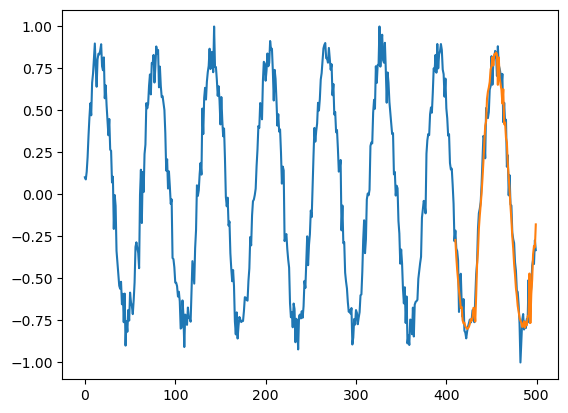

In [4]:
plt.plot(data)
plt.plot(np.arange(410, 500), y_pred)